In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:39 - loss: 0.0441 - STD: 1.7493e-04 - MAE: 0.2018

 4/64 [>.............................] - ETA: 1s - loss: 0.0274 - STD: 2.4069e-04 - MAE: 0.1234  

 5/64 [=>............................] - ETA: 2s - loss: 0.0276 - STD: 2.3004e-04 - MAE: 0.1238

 6/64 [=>............................] - ETA: 2s - loss: 0.0271 - STD: 2.2362e-04 - MAE: 0.1216

 7/64 [==>...........................] - ETA: 2s - loss: 0.0260 - STD: 2.2439e-04 - MAE: 0.1165

 8/64 [==>...........................] - ETA: 2s - loss: 0.0245 - STD: 2.3204e-04 - MAE: 0.1098

 9/64 [===>..........................] - ETA: 2s - loss: 0.0232 - STD: 2.4586e-04 - MAE: 0.1050

10/64 [===>..........................] - ETA: 2s - loss: 0.0223 - STD: 2.6319e-04 - MAE: 0.1036

11/64 [====>.........................] - ETA: 2s - loss: 0.0217 - STD: 2.8170e-04 - MAE: 0.1043

12/64 [====>.........................] - ETA: 2s - loss: 0.0214 - STD: 3.0007e-04 - MAE: 0.1056

13/64 [=====>........................] - ETA: 2s - loss: 0.0211 - STD: 3.1775e-04 - MAE: 0.1063

14/64 [=====>........................] - ETA: 2s - loss: 0.0207 - STD: 3.3393e-04 - MAE: 0.1060

15/64 [======>.......................] - ETA: 2s - loss: 0.0202 - STD: 3.4887e-04 - MAE: 0.1046

16/64 [======>.......................] - ETA: 2s - loss: 0.0197 - STD: 3.6167e-04 - MAE: 0.1024

17/64 [======>.......................] - ETA: 2s - loss: 0.0193 - STD: 3.7225e-04 - MAE: 0.0999

18/64 [=======>......................] - ETA: 2s - loss: 0.0189 - STD: 3.8189e-04 - MAE: 0.0976

19/64 [=======>......................] - ETA: 2s - loss: 0.0187 - STD: 3.9072e-04 - MAE: 0.0957

20/64 [========>.....................] - ETA: 2s - loss: 0.0185 - STD: 3.9974e-04 - MAE: 0.0941

21/64 [========>.....................] - ETA: 2s - loss: 0.0183 - STD: 4.0853e-04 - MAE: 0.0925

22/64 [=========>....................] - ETA: 2s - loss: 0.0181 - STD: 4.1895e-04 - MAE: 0.0910

23/64 [=========>....................] - ETA: 2s - loss: 0.0179 - STD: 4.2995e-04 - MAE: 0.0895

24/64 [==========>...................] - ETA: 2s - loss: 0.0176 - STD: 4.4265e-04 - MAE: 0.0884

25/64 [==========>...................] - ETA: 2s - loss: 0.0174 - STD: 4.5649e-04 - MAE: 0.0876

26/64 [===========>..................] - ETA: 2s - loss: 0.0172 - STD: 4.7159e-04 - MAE: 0.0871

27/64 [===========>..................] - ETA: 2s - loss: 0.0171 - STD: 4.8730e-04 - MAE: 0.0870

28/64 [============>.................] - ETA: 2s - loss: 0.0170 - STD: 5.0362e-04 - MAE: 0.0870

29/64 [============>.................] - ETA: 2s - loss: 0.0169 - STD: 5.2005e-04 - MAE: 0.0870

30/64 [=============>................] - ETA: 2s - loss: 0.0167 - STD: 5.3611e-04 - MAE: 0.0870

31/64 [=============>................] - ETA: 2s - loss: 0.0166 - STD: 5.5269e-04 - MAE: 0.0868

32/64 [==============>...............] - ETA: 2s - loss: 0.0165 - STD: 5.6880e-04 - MAE: 0.0864

33/64 [==============>...............] - ETA: 1s - loss: 0.0164 - STD: 5.8499e-04 - MAE: 0.0859

34/64 [==============>...............] - ETA: 1s - loss: 0.0162 - STD: 6.0084e-04 - MAE: 0.0853

35/64 [===============>..............] - ETA: 1s - loss: 0.0161 - STD: 6.1687e-04 - MAE: 0.0847

36/64 [===============>..............] - ETA: 1s - loss: 0.0160 - STD: 6.3267e-04 - MAE: 0.0841

37/64 [================>.............] - ETA: 1s - loss: 0.0159 - STD: 6.4929e-04 - MAE: 0.0834

38/64 [================>.............] - ETA: 1s - loss: 0.0159 - STD: 6.6678e-04 - MAE: 0.0828

39/64 [=================>............] - ETA: 1s - loss: 0.0158 - STD: 6.8547e-04 - MAE: 0.0823

40/64 [=================>............] - ETA: 1s - loss: 0.0157 - STD: 7.0525e-04 - MAE: 0.0819

41/64 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 7.2634e-04 - MAE: 0.0815

42/64 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 7.4961e-04 - MAE: 0.0813

43/64 [===================>..........] - ETA: 1s - loss: 0.0155 - STD: 7.7375e-04 - MAE: 0.0812

44/64 [===================>..........] - ETA: 1s - loss: 0.0154 - STD: 7.9983e-04 - MAE: 0.0810

45/64 [====================>.........] - ETA: 1s - loss: 0.0154 - STD: 8.2606e-04 - MAE: 0.0809

48/64 [=====================>........] - ETA: 1s - loss: 0.0152 - STD: 9.1550e-04 - MAE: 0.0805

50/64 [======================>.......] - ETA: 1s - loss: 0.0151 - STD: 9.8057e-04 - MAE: 0.0801

51/64 [======================>.......] - ETA: 0s - loss: 0.0151 - STD: 0.0010 - MAE: 0.0798    

52/64 [=======================>......] - ETA: 0s - loss: 0.0150 - STD: 0.0011 - MAE: 0.0795

53/64 [=======================>......] - ETA: 0s - loss: 0.0150 - STD: 0.0011 - MAE: 0.0792

54/64 [========================>.....] - ETA: 0s - loss: 0.0149 - STD: 0.0011 - MAE: 0.0790

55/64 [========================>.....] - ETA: 0s - loss: 0.0149 - STD: 0.0012 - MAE: 0.0787

56/64 [=========================>....] - ETA: 0s - loss: 0.0148 - STD: 0.0012 - MAE: 0.0786

57/64 [=========================>....] - ETA: 0s - loss: 0.0148 - STD: 0.0013 - MAE: 0.0784

58/64 [==========================>...] - ETA: 0s - loss: 0.0147 - STD: 0.0013 - MAE: 0.0783

59/64 [==========================>...] - ETA: 0s - loss: 0.0147 - STD: 0.0014 - MAE: 0.0782

60/64 [===========================>..] - ETA: 0s - loss: 0.0146 - STD: 0.0015 - MAE: 0.0781

61/64 [===========================>..] - ETA: 0s - loss: 0.0146 - STD: 0.0015 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0146 - STD: 0.0016 - MAE: 0.0778

63/64 [============================>.] - ETA: 0s - loss: 0.0145 - STD: 0.0017 - MAE: 0.0777

64/64 [==============================] - ETA: 0s - loss: 0.0145 - STD: 0.0018 - MAE: 0.0775

64/64 [==============================] - 7s 82ms/step - loss: 0.0145 - STD: 0.0018 - MAE: 0.0775 - val_loss: 0.0155 - val_STD: 0.0056 - val_MAE: 0.0738


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0116 - STD: 0.0077 - MAE: 0.0651

 2/64 [..............................] - ETA: 4s - loss: 0.0114 - STD: 0.0080 - MAE: 0.0644

 3/64 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.0084 - MAE: 0.0645

 4/64 [>.............................] - ETA: 4s - loss: 0.0114 - STD: 0.0088 - MAE: 0.0645

 5/64 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.0093 - MAE: 0.0647

 6/64 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.0098 - MAE: 0.0651

 7/64 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.0103 - MAE: 0.0652

 8/64 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.0109 - MAE: 0.0654

 9/64 [===>..........................] - ETA: 3s - loss: 0.0112 - STD: 0.0115 - MAE: 0.0655

10/64 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 0.0121 - MAE: 0.0653

11/64 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 0.0128 - MAE: 0.0650

12/64 [====>.........................] - ETA: 3s - loss: 0.0109 - STD: 0.0136 - MAE: 0.0647

13/64 [=====>........................] - ETA: 3s - loss: 0.0108 - STD: 0.0144 - MAE: 0.0642

14/64 [=====>........................] - ETA: 3s - loss: 0.0107 - STD: 0.0152 - MAE: 0.0639

15/64 [======>.......................] - ETA: 3s - loss: 0.0106 - STD: 0.0162 - MAE: 0.0635

16/64 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.0172 - MAE: 0.0631

17/64 [======>.......................] - ETA: 3s - loss: 0.0104 - STD: 0.0183 - MAE: 0.0628

18/64 [=======>......................] - ETA: 3s - loss: 0.0103 - STD: 0.0195 - MAE: 0.0624

19/64 [=======>......................] - ETA: 2s - loss: 0.0101 - STD: 0.0208 - MAE: 0.0620

20/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0221 - MAE: 0.0615

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0234 - MAE: 0.0610

22/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0248 - MAE: 0.0606

23/64 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.0263 - MAE: 0.0601

24/64 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0278 - MAE: 0.0597

25/64 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 0.0294 - MAE: 0.0593

26/64 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.0310 - MAE: 0.0589

27/64 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0325 - MAE: 0.0585

28/64 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.0340 - MAE: 0.0581

29/64 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.0355 - MAE: 0.0577

30/64 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0369 - MAE: 0.0573

31/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0384 - MAE: 0.0569

32/64 [==============>...............] - ETA: 2s - loss: 0.0084 - STD: 0.0398 - MAE: 0.0565

33/64 [==============>...............] - ETA: 2s - loss: 0.0083 - STD: 0.0412 - MAE: 0.0561

34/64 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0424 - MAE: 0.0557

36/64 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0448 - MAE: 0.0550

37/64 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.0460 - MAE: 0.0546

38/64 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0471 - MAE: 0.0543

39/64 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0483 - MAE: 0.0539

40/64 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0493 - MAE: 0.0536

41/64 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0503 - MAE: 0.0533

42/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0513 - MAE: 0.0529

43/64 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0523 - MAE: 0.0526

44/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0533 - MAE: 0.0523

45/64 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0542 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0550 - MAE: 0.0517

47/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0558 - MAE: 0.0514

48/64 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0567 - MAE: 0.0511

49/64 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0575 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0583 - MAE: 0.0506

51/64 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0590 - MAE: 0.0503

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0597 - MAE: 0.0500

53/64 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0604 - MAE: 0.0498

54/64 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0611 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0618 - MAE: 0.0493

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0624 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0629 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0635 - MAE: 0.0486

59/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0641 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0647 - MAE: 0.0482

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0652 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0657 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0663 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0667 - MAE: 0.0474

64/64 [==============================] - 4s 69ms/step - loss: 0.0060 - STD: 0.0667 - MAE: 0.0474 - val_loss: 0.0036 - val_STD: 0.0747 - val_MAE: 0.0390


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0350

 2/64 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0981 - MAE: 0.0351

 3/64 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0988 - MAE: 0.0350

 4/64 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0983 - MAE: 0.0347

 5/64 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0979 - MAE: 0.0347

 6/64 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0349

 7/64 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0349

 8/64 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0349

 9/64 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0348

10/64 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0347

11/64 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0997 - MAE: 0.0347

12/64 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0996 - MAE: 0.0346

13/64 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0346

14/64 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0345

15/64 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0345

16/64 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0344

17/64 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0344

18/64 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1001 - MAE: 0.0343

19/64 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0343

20/64 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0343

21/64 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0343

22/64 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0342

23/64 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1002 - MAE: 0.0342

24/64 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1003 - MAE: 0.0341

25/64 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0341

26/64 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0340

27/64 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0340

28/64 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0339

29/64 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0339

30/64 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0338

31/64 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0338

32/64 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0338

33/64 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1003 - MAE: 0.0337

34/64 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1004 - MAE: 0.0337

35/64 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1006 - MAE: 0.0337

36/64 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1005 - MAE: 0.0336

37/64 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1004 - MAE: 0.0336

38/64 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0335

39/64 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0335

40/64 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0335

41/64 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0334

42/64 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0334

43/64 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0334

44/64 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0333

46/64 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0333

47/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0332

48/64 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1005 - MAE: 0.0332

49/64 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0332

50/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0331

51/64 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1007 - MAE: 0.0331

52/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0331

53/64 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0331

54/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0330

55/64 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1008 - MAE: 0.0330

56/64 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0330

57/64 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0330

58/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0329

59/64 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0329

60/64 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0329

61/64 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0329

62/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1009 - MAE: 0.0329

63/64 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0328

64/64 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1010 - MAE: 0.0328

64/64 [==============================] - 4s 69ms/step - loss: 0.0024 - STD: 0.1010 - MAE: 0.0328 - val_loss: 0.0025 - val_STD: 0.0834 - val_MAE: 0.0338


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0311

 2/64 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

 3/64 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0313

 4/64 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0313

 5/64 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0313

 6/64 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0312

 7/64 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0313

 8/64 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0312

 9/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0312

10/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0312

11/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0313

12/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0312

13/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0312

14/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0312

15/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0311

16/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0311

17/64 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0311

18/64 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0311

19/64 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0311

20/64 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0310

21/64 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0310

22/64 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

23/64 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

24/64 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

25/64 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

26/64 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

27/64 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

28/64 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

29/64 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

30/64 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

31/64 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

32/64 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

33/64 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0310

34/64 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0309

35/64 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0309

36/64 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0309

37/64 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0309

39/64 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0309

40/64 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0308

41/64 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0308

42/64 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0308

43/64 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0308

44/64 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0308

45/64 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0308

46/64 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0308

47/64 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0308

48/64 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0308

49/64 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0308

50/64 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0308

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0308

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0308

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0308

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0308

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0308

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0308

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0307

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0307

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0307

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0307

61/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0307

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0307

63/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0307

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0307

64/64 [==============================] - 4s 68ms/step - loss: 0.0020 - STD: 0.1029 - MAE: 0.0307 - val_loss: 0.0025 - val_STD: 0.0855 - val_MAE: 0.0331


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0307

 2/64 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0307

 3/64 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

 4/64 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0303

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0301

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0302

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0302

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0302

 9/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0302

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0303

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0303

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0303

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

35/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

36/64 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

37/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0303

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0302

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0302

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0300

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

64/64 [==============================] - 4s 68ms/step - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300 - val_loss: 0.0025 - val_STD: 0.0928 - val_MAE: 0.0325


Epoch 6/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1068 - MAE: 0.0297

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0293

 5/64 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0295

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0294

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0294

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0295

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0295

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

14/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

15/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

16/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

17/64 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

18/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

19/64 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0295

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0295

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0294

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0295

34/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0295

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0294

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

49/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0294

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0293

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0293

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0293

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0293

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0293

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0293

64/64 [==============================] - 4s 69ms/step - loss: 0.0018 - STD: 0.1038 - MAE: 0.0293 - val_loss: 0.0023 - val_STD: 0.0865 - val_MAE: 0.0326


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0305

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0299

 3/64 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0299

 4/64 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

 5/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

 6/64 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0299

 7/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0301

 8/64 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0299

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0304

10/64 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

11/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0309

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0309

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0311

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0309

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0310

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0308

19/64 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0310

20/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0308

21/64 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0309

22/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308

23/64 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0307

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0307

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0306

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0305

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0302

34/64 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0302

35/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0302

36/64 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

37/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

38/64 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0301

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0299

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0299

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0298

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295

64/64 [==============================] - 4s 69ms/step - loss: 0.0019 - STD: 0.1036 - MAE: 0.0295 - val_loss: 0.0022 - val_STD: 0.0921 - val_MAE: 0.0310


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0287

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0286

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0285

 4/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0285

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0285

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0285

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0286

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0286

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0286

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0286

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - 4s 69ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.0928 - val_MAE: 0.0307


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

 2/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0277

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

64/64 [==============================] - 4s 65ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281 - val_loss: 0.0022 - val_STD: 0.0922 - val_MAE: 0.0304


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0274

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

 3/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0277

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0277

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1031 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0278

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0278

13/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0278

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0278

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0278

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0277

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0277

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0276

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0277

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0277

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0277

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0278

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0278

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

49/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0278

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

64/64 [==============================] - 4s 62ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278 - val_loss: 0.0021 - val_STD: 0.0931 - val_MAE: 0.0301


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0275

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0275

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

10/64 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0278

11/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

12/64 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

13/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

14/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

16/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

17/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

18/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

19/64 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

20/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

21/64 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

22/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

24/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0279

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

64/64 [==============================] - 4s 61ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278 - val_loss: 0.0021 - val_STD: 0.0938 - val_MAE: 0.0300


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0272

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0271

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0271

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

13/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0269

14/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0270

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0270

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0270

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0270

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

64/64 [==============================] - 4s 61ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272 - val_loss: 0.0020 - val_STD: 0.0906 - val_MAE: 0.0298


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0276

 2/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0286

 3/64 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0289

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1070 - MAE: 0.0286

 5/64 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1074 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0288

 8/64 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0286

 9/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0285

10/64 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0285

11/64 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

12/64 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0282

13/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

14/64 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0281

15/64 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0279

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0278

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

29/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

64/64 [==============================] - 4s 59ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0022 - val_STD: 0.0963 - val_MAE: 0.0299


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0269

 2/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0271

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0271

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0271

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0271

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0269

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0269

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0270

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0270

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0269

47/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269

64/64 [==============================] - 4s 59ms/step - loss: 0.0016 - STD: 0.1055 - MAE: 0.0269 - val_loss: 0.0020 - val_STD: 0.0910 - val_MAE: 0.0299


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0274

 2/64 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1088 - MAE: 0.0300

 3/64 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1031 - MAE: 0.0324

 4/64 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0320

 5/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1059 - MAE: 0.0309

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0308

 7/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0310

 8/64 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0306

 9/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0302

10/64 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0301

11/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0300

12/64 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

13/64 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0298

14/64 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0299

15/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

16/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0298

17/64 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0298

18/64 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0297

19/64 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0299

20/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0300

21/64 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

22/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0302

23/64 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0301

24/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0301

25/64 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0302

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0301

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0301

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0300

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0300

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

32/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298

33/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298

34/64 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

35/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0296

36/64 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0296

37/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0296

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0295

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0294

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0292

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0290

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

49/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0289

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0288

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0287

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0287

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0286

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0286

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 4s 66ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0943 - val_MAE: 0.0289


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0262

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0263

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0265

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0266

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0266

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0950 - val_MAE: 0.0289


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0259

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0264

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0264

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0265

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.0946 - val_MAE: 0.0289


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0263

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0262

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266 - val_loss: 0.0020 - val_STD: 0.0951 - val_MAE: 0.0287


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0264

 4/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0267

 5/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0265

 6/64 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1039 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0264

10/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0265

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0266

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0265

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0265

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

64/64 [==============================] - 4s 60ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263 - val_loss: 0.0022 - val_STD: 0.0983 - val_MAE: 0.0301


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0270

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0261

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266 - val_loss: 0.0020 - val_STD: 0.0957 - val_MAE: 0.0288


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0261

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - 4s 60ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263 - val_loss: 0.0019 - val_STD: 0.0953 - val_MAE: 0.0284


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0256

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0257

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0257

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

11/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

12/64 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

13/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

14/64 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

15/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

16/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

17/64 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - 4s 60ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0928 - val_MAE: 0.0287


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0267

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0269

 3/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0271

 4/64 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1069 - MAE: 0.0270

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0263

10/64 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0263

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0262

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0262

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0262

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0261

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0261

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0260

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

32/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0261

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0262

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0261

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 4s 62ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0019 - val_STD: 0.0902 - val_MAE: 0.0300


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

 2/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0298

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0293

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0281

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0281

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0279

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0277

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0277

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0273

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0272

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0271

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0271

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

64/64 [==============================] - 4s 61ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264 - val_loss: 0.0020 - val_STD: 0.0968 - val_MAE: 0.0284


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0256

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0260

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0260

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - 4s 67ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0018 - val_STD: 0.0946 - val_MAE: 0.0281


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0257

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0255

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0940 - val_MAE: 0.0279


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1001 - MAE: 0.0257

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1038 - MAE: 0.0256

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0261

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0261

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 4s 68ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0020 - val_STD: 0.0964 - val_MAE: 0.0286


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0252

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 4s 68ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0021 - val_STD: 0.0982 - val_MAE: 0.0291


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0259

 2/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1090 - MAE: 0.0255

 3/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0257

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0255

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0254

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 4s 69ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0018 - val_STD: 0.0960 - val_MAE: 0.0279


Epoch 30/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1039 - MAE: 0.0254

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0259

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0260

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0259

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257 - val_loss: 0.0019 - val_STD: 0.0896 - val_MAE: 0.0302


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.0971 - MAE: 0.0297

 2/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0286

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0275

 5/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0279

 6/64 [=>............................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0278

 7/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

10/64 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0276

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0277

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0280

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0281

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0280

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0281

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0280

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0280

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0280

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0281

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0280

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0281

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0280

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

64/64 [==============================] - 4s 69ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270 - val_loss: 0.0019 - val_STD: 0.0973 - val_MAE: 0.0284


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0013 - STD: 0.1083 - MAE: 0.0249

 2/64 [..............................] - ETA: 4s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0249

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0252

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0251

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

33/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - 4s 66ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0018 - val_STD: 0.0961 - val_MAE: 0.0277


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0254

 4/64 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

 6/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

 8/64 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0251

10/64 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0252

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0252

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

18/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0252

19/64 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

20/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

21/64 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

22/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

35/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

36/64 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

37/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 4s 67ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0020 - val_STD: 0.0985 - val_MAE: 0.0287


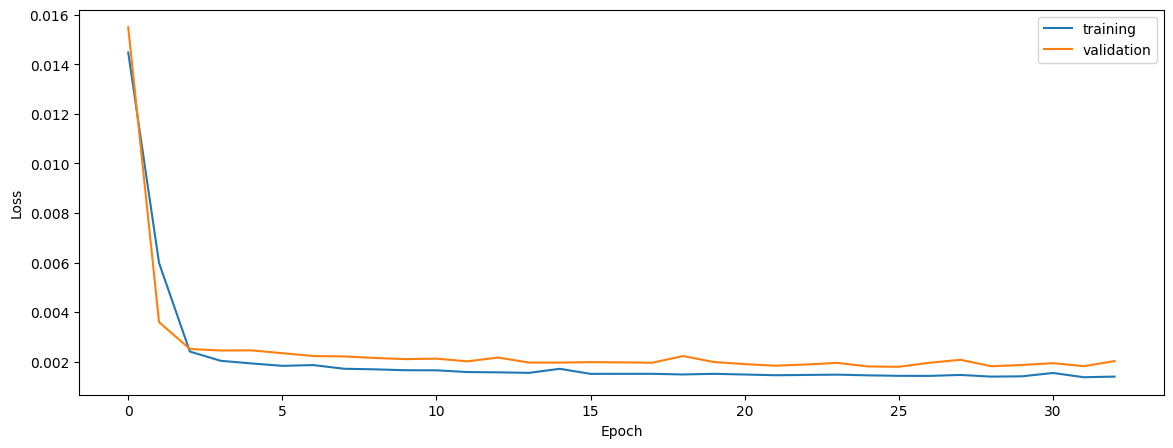

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9435737987171592
0.9473336778961671
0.9448678773161407


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.9435737987171592
0.9473336778961671
0.9448678773161407


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.9493826104952856
0.9512899531980468
0.9557693787629147


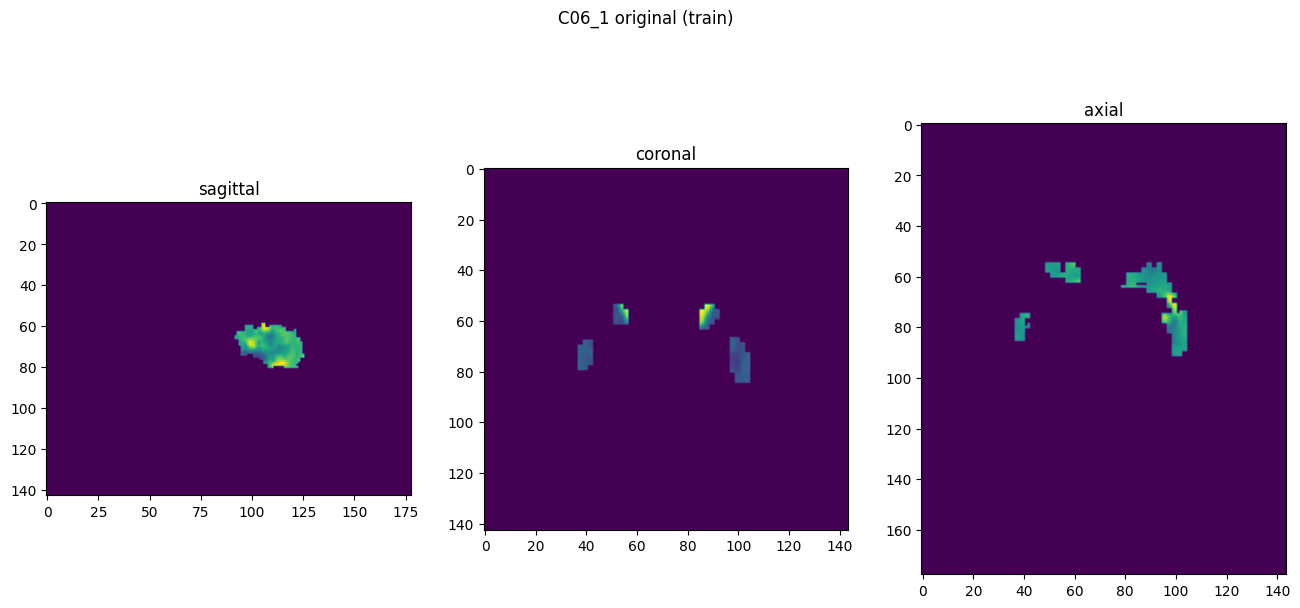

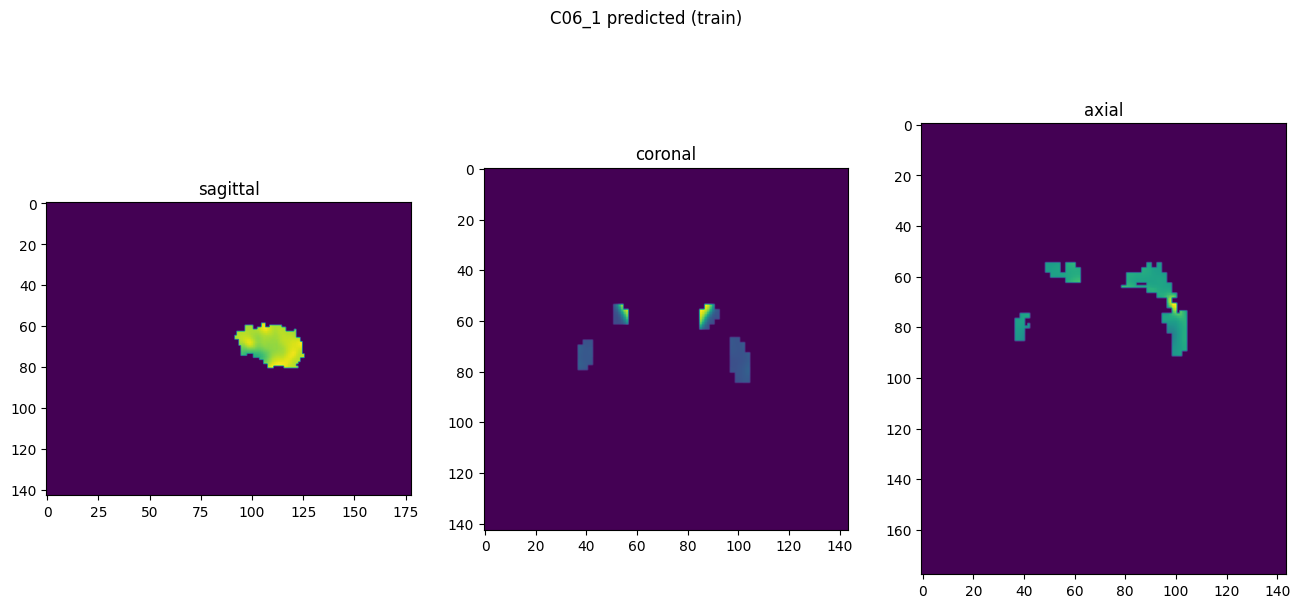

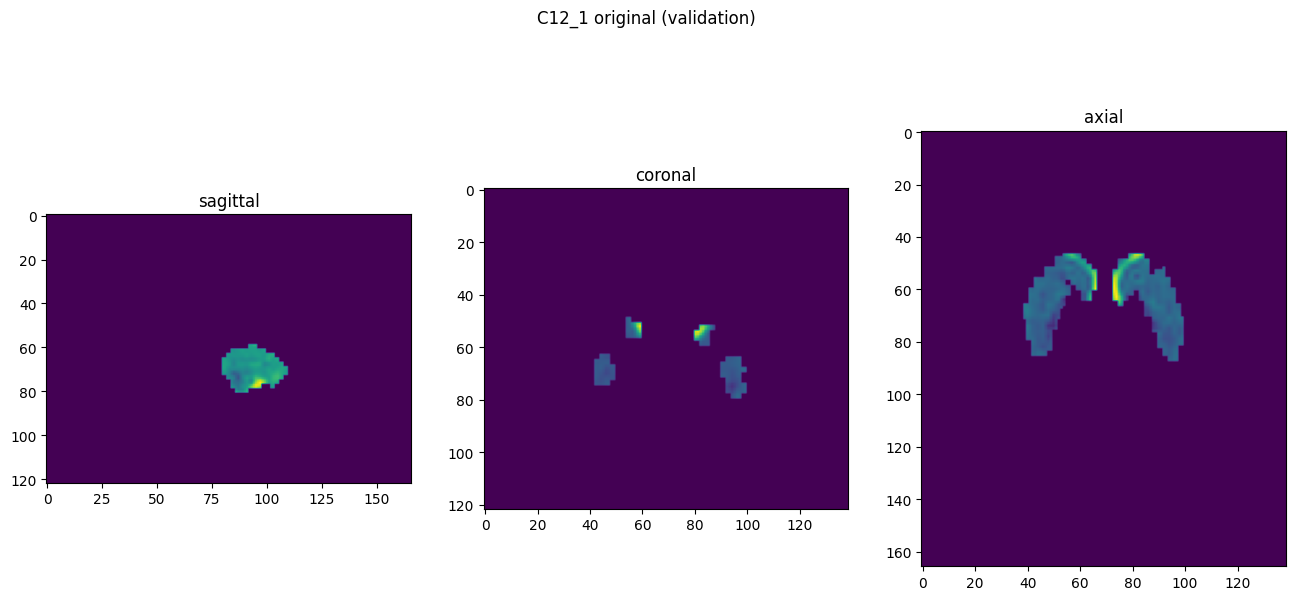

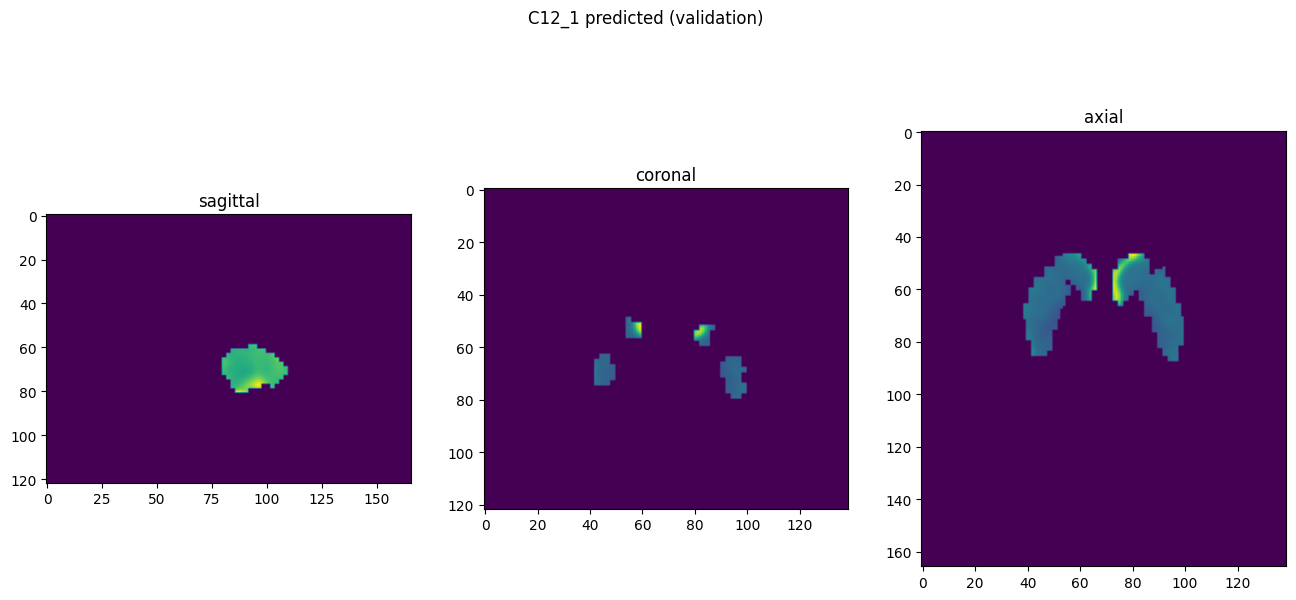

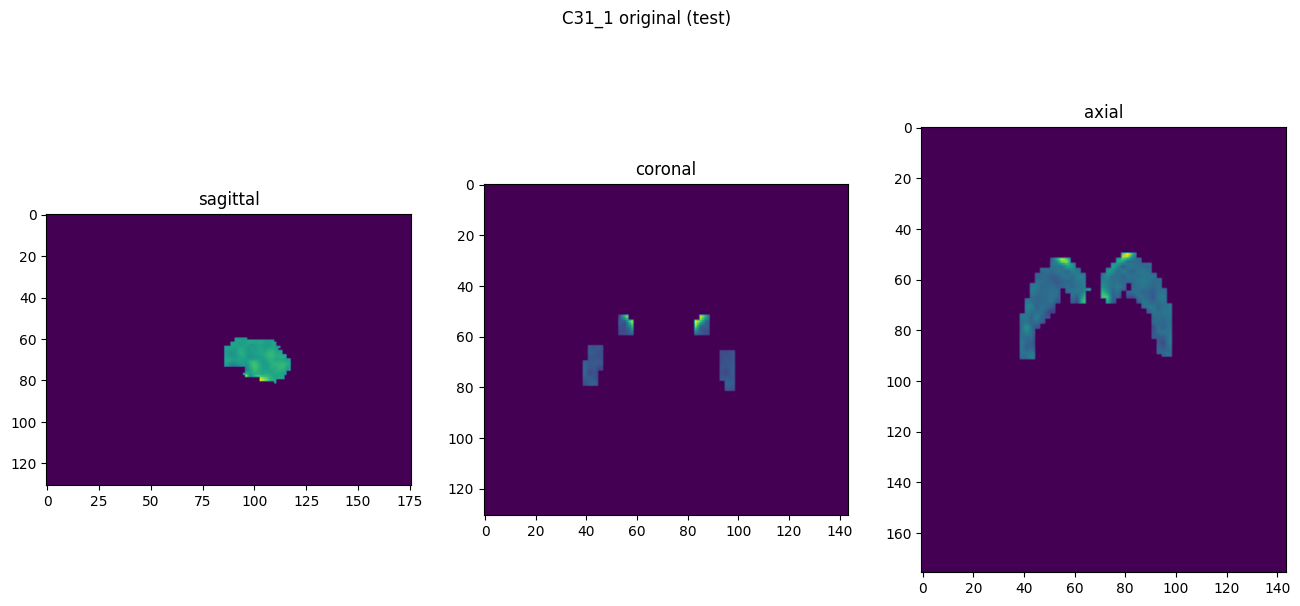

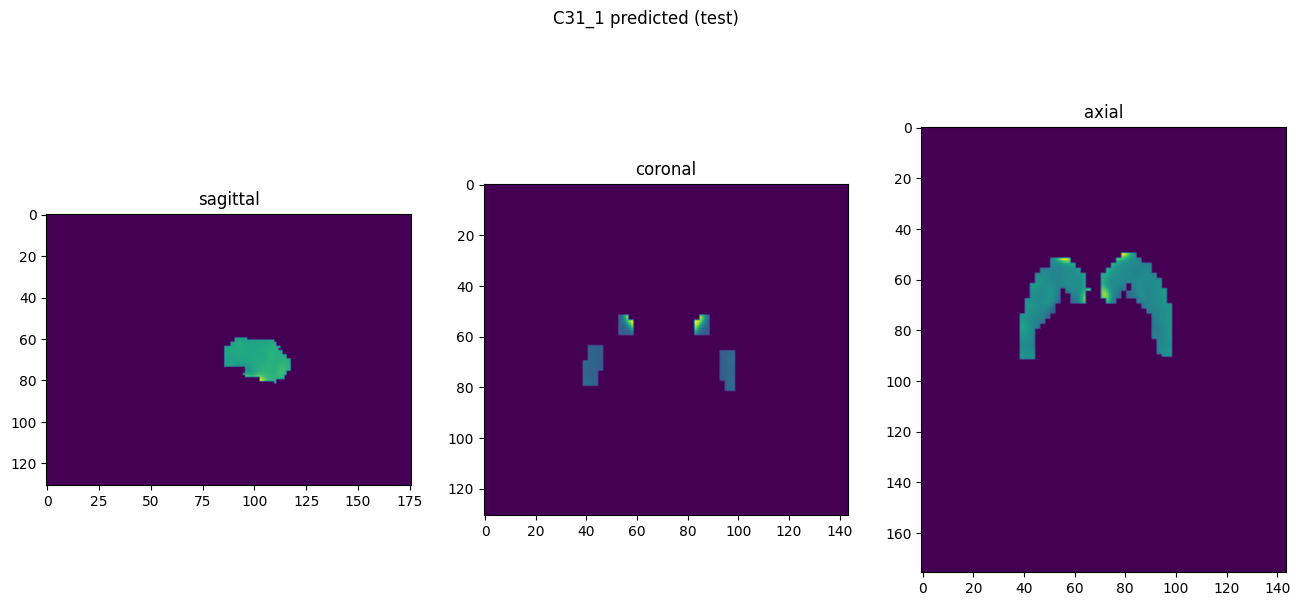

In [10]:
showResults(model, gen, threshold=None, background=False)